In [1]:
using Clapeyron
using Plots
using CSV
using DataFrames
using LaTeXStrings
using Measures

In [2]:
model_mix = SAFTgammaMie([("MEA",["NH2"=>1, "CH2"=>1, "CH2OH"=>1]),("Water",["H2O"=>1]),("Carbon Dioxide",["CO2"=>1]),("Sulphur Dioxide",["SO2"=>1])];

        userlocations = (Mw = [16.02285, 14.02658, 31.03392, 18.01528, 44.01, 64.066],

        epsilon = [284.78 348.39 528.21 339.89 134.58 453.85;
                   348.39 473.39 423.17 423.63 276.45 301.96;
                   528.21 423.17 407.22 358.02 312.3 302.89;
                   339.89 423.63 358.02 266.68 226.38 239.53;                  
                   134.58 276.45 312.3 226.38 207.89 233.15;                  
                   453.85 301.96 302.89 239.53 233.15 237.54],
        sigma = [3.2477, 4.8801, 3.4054, 3.0063, 3.05, 3.1605],
        lambda_a = [6, 6, 6, 6, 5.055, 6],
        lambda_r = [10.354 14.063 52.305 13.085 50.06 12.412;
                    14.063 19.871 21.230 100.00 22.873 17.354;
                    52.305 21.230 22.699 19.619 24.474 18.511;
                    13.085 100.00 19.619 17.020 21.116 16.085;           
                    50.06  22.873 24.474 21.116 26.408 19.908;           
                    12.412 17.354 18.511 16.085 19.908 15.213],
        vst = [1, 1, 2, 1, 2, 3],
        S = [0.79675, 0.22932, 0.58538, 1, 0.84680, 0.62547],
        n_H=[2, 0, 1, 2, 0, 1],
        n_e=[1, 0, 2, 2, 0, 1],
        n_a1=[0, 0, 0, 0, 1, 0],
        n_a2=[0, 0, 0, 0, 1, 0],
        epsilon_assoc = Dict([(("NH2","H"),("NH2","e")) => 1070.80,
                              (("NH2","H"),("CH2OH","e")) => 629.88,
                              (("NH2","H"),("H2O","e")) => 1364.40,
                              (("NH2","H"),("SO2","e")) => 663.02,
                              (("CH2OH","H"),("NH2","e")) => 2403.78,
                              (("CH2OH","H"),("CH2OH","e")) => 2097.90,
                              (("CH2OH","H"),("H2O","e")) => 600.00,
                              (("CH2OH","H"),("SO2","e")) => 1415.90,
                              (("H2O","H"),("NH2","e")) => 1877.50,
                              (("H2O","H"),("CH2OH","e")) => 2000.6,
                              (("H2O","H"),("H2O","e")) => 1985.40,
                              (("H2O","H"),("SO2","e")) => 1343.90,
                              (("SO2","H"),("NH2","e")) => 663.02,
                              (("SO2","H"),("CH2OH","e")) => 1415.90,
                              (("SO2","H"),("H2O","e")) => 1343.90,
                              (("SO2","H"),("SO2","e")) => 955.58,
                              (("CO2","a1"),("NH2","e")) => 3313,               
                              (("CO2","a1"),("H2O","e")) => 1398.1,                 
                              (("CO2","a2"),("NH2","e")) => 4943.6]),
        bondvol = Dict([(("NH2","H"),("NH2","e")) => 95.225e-30,
                              (("NH2","H"),("CH2OH","e")) => 346.08e-30,
                              (("NH2","H"),("H2O","e")) => 22.450e-30,
                              (("NH2","H"),("SO2","e")) => 345.890e-30,
                              (("CH2OH","H"),("NH2","e")) => 26.192e-30,
                              (("CH2OH","H"),("CH2OH","e")) => 62.309e-30,
                              (("CH2OH","H"),("H2O","e")) => 490.19e-30,
                              (("CH2OH","H"),("SO2","e")) => 303.270e-30,
                              (("H2O","H"),("NH2","e")) => 459.18e-30,
                              (("H2O","H"),("CH2OH","e")) => 130.02e-30,
                              (("H2O","H"),("H2O","e")) => 101.69e-30,
                              (("H2O","H"),("SO2","e")) => 353.41e-30,
                              (("SO2","H"),("NH2","e")) => 345.890e-30,                
                              (("SO2","H"),("CH2OH","e")) => 303.270e-30,                
                              (("SO2","H"),("H2O","e")) => 353.41e-30,               
                              (("SO2","H"),("SO2","e")) => 849.99e-30,
                              (("CO2","a1"),("NH2","e")) => 3280.3e-30,               
                              (("CO2","a1"),("H2O","e")) => 91.419e-30,                
                              (("CO2","a2"),("NH2","e")) => 142.64e-30])));

In [3]:
sulphload = [0, 0.01, 0.1, 0.2]
Nsulph = length(sulphload)

4

In [4]:
wt_MEA = 0.3
wt_H2O = 1-wt_MEA

mw_MEA = 61.08
mw_H2O = 18.01528

x_MEA = (wt_MEA/mw_MEA)*(1/((wt_MEA/mw_MEA)+(wt_H2O/mw_H2O)))
x_H2O = 1-x_MEA
solvrat = x_H2O/x_MEA

7.911062165006595

In [5]:
load = LinRange(0, 1.2, 100) #these are the ratio of CO2 mols to MEA mols in solution

N = length(load)

# intialise new composition vectors
MEAsol = zeros(N, Nsulph)
H2Osol = zeros(N, Nsulph)
CO2sol = zeros(N, Nsulph)
SO2sol = zeros(N, Nsulph)
Ncomp = Nsulph*4
z = zeros(N, Ncomp)

# calculate the new liquid compositions at these loadings

for j in 1:Nsulph
MEAsol[:,j] = 1 ./ (1 .+ load .+ solvrat .+ sulphload[j])
CO2sol[:,j] = MEAsol[:,j] .* load
SO2sol[:,j] = MEAsol[:,j] .* sulphload[j]       
H2Osol[:,j] = 1 .- MEAsol[:,j] .- CO2sol[:,j] .- SO2sol[:,j]
ind = 1 + (4 * (j-1) )
z[:, ind] = MEAsol[:,j]
z[:, ind+1] = H2Osol[:,j]
z[:, ind+2] = CO2sol[:,j]
z[:, ind+3] = SO2sol[:,j]
end

#z should be in the order MEA, H20, CO2 and then SO2 composition
z


100×16 Matrix{Float64}:
 0.11222    0.88778   0.0         0.0  …  0.868292  0.0         0.0219513
 0.112068   0.886574  0.0013584   0.0     0.867138  0.00132862  0.0219222
 0.111916   0.885371  0.00271311  0.0     0.865988  0.00265371  0.0218931
 0.111764   0.884172  0.00406415  0.0     0.86484   0.00397529  0.0218641
 0.111613   0.882976  0.00541153  0.0     0.863696  0.00529337  0.0218351
 0.111462   0.881783  0.00675527  0.0  …  0.862554  0.00660796  0.0218063
 0.111312   0.880593  0.00809539  0.0     0.861416  0.00791909  0.0217775
 0.111162   0.879406  0.0094319   0.0     0.86028   0.00922676  0.0217488
 0.111012   0.878223  0.0107648   0.0     0.859148  0.010531    0.0217202
 0.110863   0.877043  0.0120941   0.0     0.858019  0.0118318   0.0216916
 0.110714   0.875866  0.0134199   0.0  …  0.856892  0.0131292   0.0216631
 0.110566   0.874692  0.0147421   0.0     0.855768  0.0144232   0.0216347
 0.110418   0.873522  0.0160608   0.0     0.854648  0.0157137   0.0216064
 ⋮            

In [6]:
T = 298.15
pvap = zeros(N, Nsulph)
y = zeros(N, Ncomp)
partial = zeros(N, 2 * Nsulph )
xNHCOO = zeros(N, Nsulph)
xHCO3 = zeros(N, Nsulph)

for k in 1:Nsulph

ind = 1 + (4 * (k-1) )
    
    for h in 1:N
        x_bub = z[h, ind:ind+3]
        calc = bubble_pressure(model_mix, T, x_bub)
        pvap[h, k] = calc[1]
        y[h, ind] = calc[4][1]
        y[h, ind+1] = calc[4][2]
        y[h, ind+2] = calc[4][3]
        y[h, ind+3] = calc[4][4]
        vl = calc[2]
        X = Clapeyron.X(model_mix, vl, T, x_bub)
        xNHCOO[h,k] = x_bub[3]*(1-X[3][1])*(1-X[3][2])
        xHCO3[h,k] = x_bub[3]*(X[3][1]+X[3][2]-2*(X[3][1]*X[3][2]))
    end

end

for k in 1:Nsulph
    ind = 1 + (4 * (k-1) )
    ind2 = 1 + (2 * (k-1) )
    partial[:, ind2] = pvap[:, k] .* y[:, ind+2]
    partial[:, ind2 + 1] = pvap[:, k] .* y[:, ind+3]
end


partialfil = partial[2:N, :]
loadfil = load[2:N]
partialfilb = partialfil ./ 1e5
xNHCOO_0 = xNHCOO[2:N,1]
xNHCOO_001 = xNHCOO[2:N,2]
xNHCOO_01 = xNHCOO[2:N,3]
xNHCOO_02 = xNHCOO[2:N,4]

xHCO3_0 = xHCO3[2:N,1]
xHCO3_001 = xHCO3[2:N,2]
xHCO3_01 = xHCO3[2:N,3]
xHCO3_02 = xHCO3[2:N,4]
#partial
#pvap
#y
#partialfilb
#xNHCOO
#odd columns are CO2 vap press, even ones are SO2 vap pressure

99-element Vector{Float64}:
 1.42322233966798e-6
 2.93723572608007e-6
 4.549292761075927e-6
 6.267418129717296e-6
 8.100513756803032e-6
 1.0058481589432049e-5
 1.2152367542025279e-5
 1.4394530972620779e-5
 1.679884511802075e-5
 1.9380935270828138e-5
 2.21584632285704e-5
 2.51514688133474e-5
 2.8382782227602567e-5
 ⋮
 0.043833001643510124
 0.044615697549969024
 0.04539135362597446
 0.04616011905732725
 0.0469221432053839
 0.04767757455990631
 0.04842655986364987
 0.049169243392076255
 0.04990576637104368
 0.05063626651529618
 0.05136087767090104
 0.05207972954523329

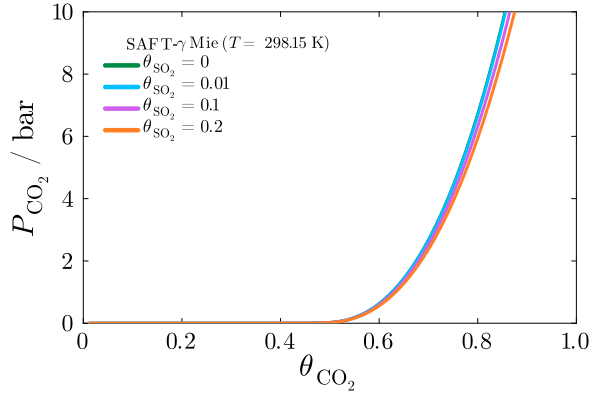

In [7]:
plt = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      xtickfont = font(16),
      ytickfont = font(16),
      #yaxis = :log,
      xlims = (0, 1),
      xticks = ([0, 0.2, 0.4, 0.6, 0.8, 1.0],[L"0", L"0.2",L"0.4",L"0.6",L"0.8",L"1.0"]),
      ylims = (0, 10),
      yticks = ([0, 2, 4, 6, 8, 10],[L"0", L"2",L"4",L"6",L"8",L"10"]),
      legend =:topleft,
      legend_spacing = 1,
      legendtitle =  L"\mathrm{SAFT}"*"-"*L"\mathrm{\gamma \ Mie} \ (\mathit{T=} \ \mathrm{298.15 \ K})",
      left_margin = 4mm,
      right_margin = 4mm,
      bottom_margin = 4mm,
      xguidefontsize= 20,
      yguidefontsize= 20)

plot!(plt, loadfil, partialfilb[:,1], 
      color = "springgreen4", 
      line = (:path, 3), 
      label = L"\theta\mathrm{_{SO_2}} = 0")

plot!(plt, loadfil, partialfilb[:, 3], 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = L"\theta\mathrm{_{SO_2}} = 0.01")

plot!(plt, loadfil, partialfilb[:, 5], 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = L"\theta\mathrm{_{SO_2}} = 0.1")

plot!(plt, loadfil, partialfilb[:, 7], 
      color = "chocolate1", 
      line = (:path, 3), 
      label = L"\theta\mathrm{_{SO_2}} = 0.2")


annotate!(plt, 0.22, 25, text(L"\mathrm{T = 298.15K}", 11, :black))
xlabel!(plt, L"\theta\mathrm{_{CO_2}}")
ylabel!(plt, L"P\mathrm{_{CO_2} \ / \ bar}")


#savefig(plt, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures\\EPSILONFITTED_SO2_Loading_Effect_CO2_298_Annotation.png")

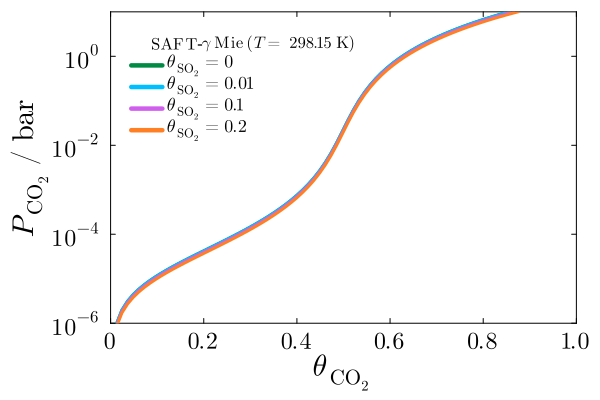

In [8]:
plt2 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      xtickfont = font(16),
      ytickfont = font(16),
      yaxis = :log,
      xlims = (0, 1),
      xticks = ([0, 0.2, 0.4, 0.6, 0.8, 1.0],[L"0", L"0.2",L"0.4",L"0.6",L"0.8",L"1.0"]),
      ylims = (0.000001, 10),
      yticks = ([0.000001, 0.0001, 0.01, 1.0],[L"10^{-6}", L"10^{-4}",L"10^{-2}",L"10^{0}"]),
      legend =:topleft,
      background_color_legend=:transparent,
      legendtitle = L"\mathrm{SAFT}"*"-"*L"\mathrm{\gamma \ Mie} \ (\mathit{T=} \ \mathrm{298.15 \ K})",
      left_margin = 4mm,
      right_margin = 4mm,
      bottom_margin = 4mm,
      xguidefontsize= 20,
      yguidefontsize= 20)

plot!(plt2, loadfil, partialfilb[:,1], 
      color = "springgreen4", 
      line = (:path, 3), 
      label = L"\theta\mathrm{_{SO_2}} = 0")

plot!(plt2, loadfil, partialfilb[:, 3], 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = L"\theta\mathrm{_{SO_2}} = 0.01")

plot!(plt2, loadfil, partialfilb[:, 5], 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = L"\theta\mathrm{_{SO_2}} = 0.1")

plot!(plt2, loadfil, partialfilb[:, 7], 
      color = "chocolate1", 
      line = (:path, 3), 
      label = L"\theta\mathrm{_{SO_2}} = 0.2")



xlabel!(plt2, L"\theta\mathrm{_{CO_2}}")
ylabel!(plt2, L"P\mathrm{_{CO_2} \ / \ bar}")

#savefig(plt2, "New_Log_SO2_Loading_Effect_CO2_298_Annotation")
#savefig(plt2, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures\\EPSILONFITTED_LOG_SO2_Loading_Effect_CO2_298_Annotation.png")

In [9]:
plt3 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      xtickfont = font(12),
      ytickfont = font(12),
      #yaxis = :log,
      xlims = (0, 1.2),
      legend =:bottomright,
      background_color_legend=:transparent,
      left_margin = 4mm,
      right_margin = 4mm,
      xguidefontsize=16,
      yguidefontsize=16)

plot!(plt3, loadfil, pvap[:,1], 
      color = "indianred2", 
      line = (:path, 3), 
      label = "No SO2")

plot!(plt3, loadfil, pvap[:, 2], 
      color = "springgreen4", 
      line = (:path, 3), 
      label = "0.01 SO2 Loading")

plot!(plt3, loadfil, pvap[:, 3], 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = "0.1 SO2 Loading")

plot!(plt3, loadfil, pvap[:, 4], 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = "0.2 SO2 Loading")



xlabel!(plt3, "θ"*L"\mathrm{_{CO_2}}")
ylabel!(plt3, "P"*L"\mathrm{_{SO_2}}"*" / Pa")

#savefig(plt, "SO2_All_Temps_Loading_298")

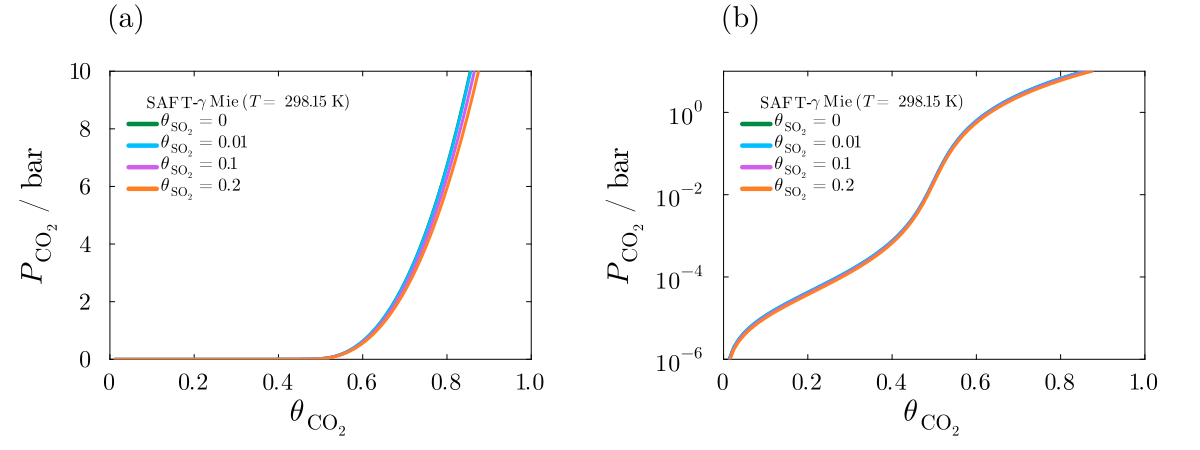

In [10]:
(plt3 = plot(plt, plt2,
    layout = (1, 2),
    size = (1200, 450),
    left_margin = 12mm,
    right_margin = 12mm,
    bottom_margin = 12mm,
    top_margin = 12mm,
    title = [L"\mathrm{(a)}" L"\mathrm{(b)}" ],
    titleloc = :left,
    titlefont = font(20)))
#savefig(plt3, "New_SO2_loading_Effect_CO2_Final.png")
#savefig(plt3, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures\\EPSILONFITTED_LOG_SO2_Loading_Effect_CO2_Subplot.pdf")
#savefig(plt3, "C:\\Users\\gk321\\OneDrive - Imperial College London\\Documents\\4th year\\Research Project\\Fitted SO2 CO2 Figures\\EPSILONFITTED_SO2_loading_Effect_CO2_Final.png")

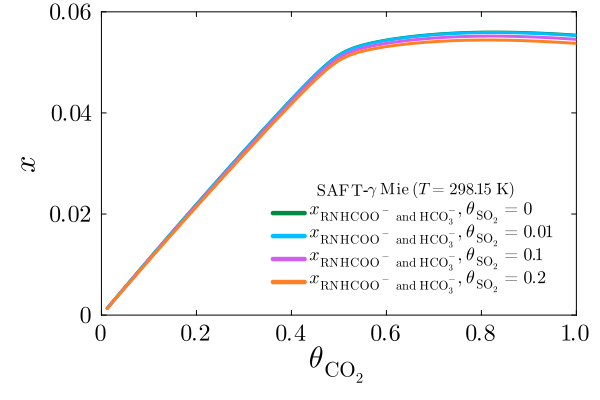

In [19]:
plt6 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle = L"\mathrm{SAFT}"*"-"*L"\mathrm{\gamma \ Mie} \ (T = 298.15 \ \mathrm{K})",
      legend_background_color=:transparent,
      xtickfont = font(16),
      ytickfont = font(16),
      xlims = (0, 1),
      ylims = (0, 0.06),
      xticks = ([0, 0.2, 0.4, 0.6, 0.8, 1.0],[L"0", L"0.2",L"0.4",L"0.6",L"0.8",L"1.0"]),
      yticks = ([0, 0.02, 0.04, 0.06],[L"0",L"0.02", L"0.04",L"0.06"]),
    size = (600, 400),
    legend =:bottomright,
      left_margin = 4mm,
      right_margin = 4mm,
    bottom_margin = 6mm,
      xguidefontsize=20,
      yguidefontsize=20)

plot!(plt6, loadfil, xNHCOO_0, 
      color = "springgreen4", 
      line = (:path, 3), 
      label = L"x_{\mathrm{RNHCOO}^- \ \mathrm{and} \ \mathrm{HCO_3^{-}}}, \theta\mathrm{_{SO_2}} = 0")

# plot!(plt6, loadfil, xHCO3_0, 
#       color = "springgreen4", 
#       line = (:dash, 3), 
#       label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0")

plot!(plt6, loadfil, xNHCOO_001, 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = L"x_{\mathrm{RNHCOO}^- \ \mathrm{and} \ \mathrm{HCO_3^{-}}}, \theta\mathrm{_{SO_2}} = 0.01")

# plot!(plt6, loadfil, xHCO3_001, 
#       color = "deepskyblue1", 
#       line = (:dash, 3), 
#       label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0.01")

plot!(plt6, loadfil, xNHCOO_01, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = L"x_{\mathrm{RNHCOO}^-\ \mathrm{and} \ \mathrm{HCO_3^{-}}}, \theta\mathrm{_{SO_2}} = 0.1")

# plot!(plt6, loadfil, xHCO3_01, 
#       color = "mediumorchid2", 
#       line = (:dash, 3), 
#       label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0.1")

plot!(plt6, loadfil, xNHCOO_02, 
      color = "chocolate1", 
      line = (:path, 3), 
      label = L"x_{\mathrm{RNHCOO}^-\ \mathrm{and} \ \mathrm{HCO_3^{-}}}, \theta\mathrm{_{SO_2}} = 0.2")

# plot!(plt6, loadfil, xHCO3_02, 
#       color = "chocolate1", 
#       line = (:dash, 3), 
#       label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0.2")

xlabel!(plt6, L"\theta_{\mathrm{CO_2}}")
ylabel!(plt6, L"x")

#savefig(plt6, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures\\CO2_Speciation_not_zoomed.png")

#savefig(plt6, "NoLeg_All_Speciation_SO2_loading_Effect_CO2.png")
#savefig(plt6, "C:\\Users\\gk321\\OneDrive - Imperial College London\\Documents\\4th year\\Research Project\\Fitted SO2 CO2 Figures\\EPSILONFITTED_All_Speciation_SO2_loading_Effect_CO2.png")

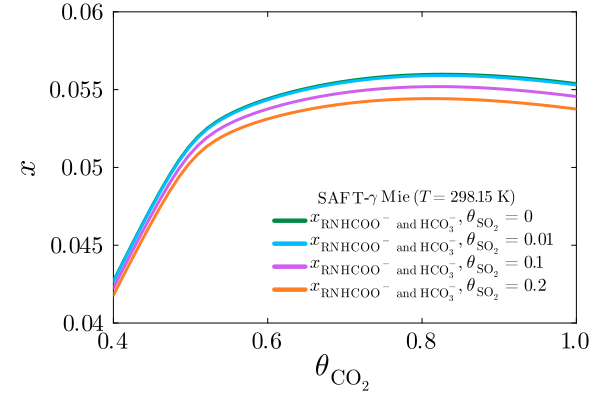

In [20]:
plt7 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle_font = font(12),
      background_color_legend=:transparent,
      legendtitle = L"\mathrm{SAFT}"*"-"*L"\mathrm{\gamma \ Mie} \ (T = 298.15 \ \mathrm{K})",
      xtickfont = font(16),
      ytickfont = font(16),
      xticks = ([0.4, 0.6, 0.8, 1.0],[L"0.4",L"0.6",L"0.8",L"1.0"]),
      yticks = ([0.04, 0.045, 0.05, 0.055, 0.06],[L"0.04",L"0.045",L"0.05",L"0.055", L"0.06"]),
      xlims = (0.4, 1),
      ylims = (0.04, 0.06),
      legend =:bottomright,
      left_margin = 4mm,
      right_margin = 4mm,
      bottom_margin = 4mm,
      xguidefontsize=20,
      yguidefontsize=20)

plot!(plt7, loadfil, xNHCOO_0, 
      color = "springgreen4", 
      line = (:path, 3), 
      label = L"x_{\mathrm{RNHCOO}^-\ \mathrm{and} \ \mathrm{HCO_3^{-}}}, \theta\mathrm{_{SO_2}} = 0")

#=plot!(plt6, loadfil, xHCO3_0, 
      color = "springgreen4", 
      line = (:dash, 3), 
      label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0")=#

plot!(plt7, loadfil, xNHCOO_001, 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = L"x_{\mathrm{RNHCOO}^-\ \mathrm{and} \ \mathrm{HCO_3^{-}}}, \theta\mathrm{_{SO_2}} = 0.01")

#=plot!(plt6, loadfil, xHCO3_001, 
      color = "deepskyblue1", 
      line = (:dash, 3), 
      label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0.01")=#

plot!(plt7, loadfil, xNHCOO_01, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = L"x_{\mathrm{RNHCOO}^-\ \mathrm{and} \ \mathrm{HCO_3^{-}}}, \theta\mathrm{_{SO_2}} = 0.1")

#=plot!(plt6, loadfil, xHCO3_01, 
      color = "mediumorchid2", 
      line = (:dash, 3), 
      label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0.1")=#

plot!(plt7, loadfil, xNHCOO_02, 
      color = "chocolate1", 
      line = (:path, 3), 
      label = L"x_{\mathrm{RNHCOO}^-\ \mathrm{and} \ \mathrm{HCO_3^{-}}}, \theta\mathrm{_{SO_2}} = 0.2")

#=plot!(plt6, loadfil, xHCO3_02, 
      color = "chocolate1", 
      line = (:dash, 3), 
      label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0.2")=#

xlabel!(plt7, L"\theta_{\mathrm{CO_2}}")
ylabel!(plt7, L"x")

#savefig(plt7, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures\\CO2_Speciation_zoomed.png")

#savefig(plt7, "NHCOO_Speciation_SO2_loading_Effect_CO2.png")
#savefig(plt7, "C:\\Users\\gk321\\OneDrive - Imperial College London\\Documents\\4th year\\Research Project\\Fitted SO2 CO2 Figures\\EPSILONFITTED_NHCOO_Speciation_SO2_loading_Effect_CO2.png")

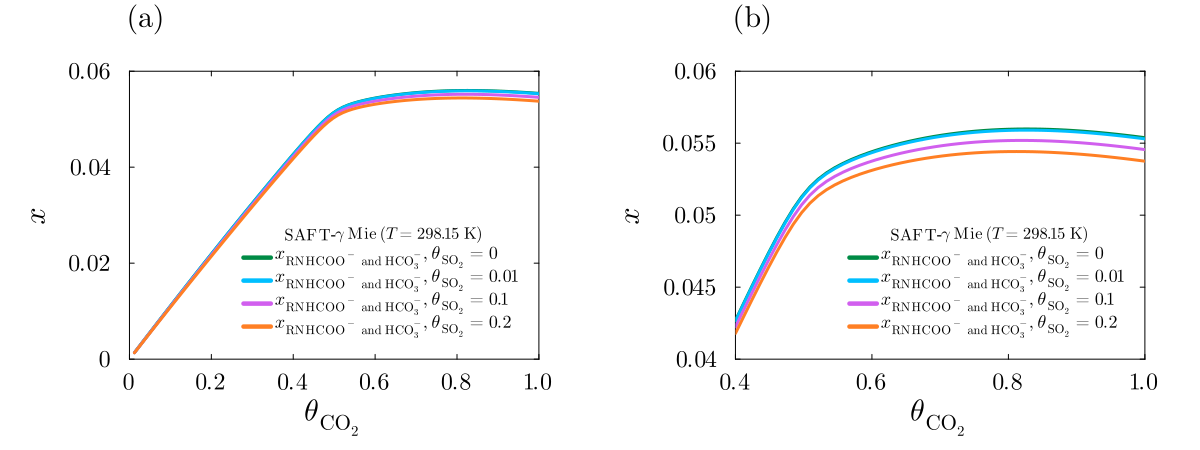

In [23]:
(plt9 = plot(plt6, plt7,
    layout = (1, 2),
    size = (1200, 450),
    left_margin = 12mm,
    right_margin = 12mm,
    bottom_margin = 12mm,
    top_margin = 12mm,
    title = [L"\mathrm{(a)}" L"\mathrm{(b)}" ],
    titleloc = :left,
    titlefont = font(20)))

#savefig(plt9, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures\\CO2_Subplot_speciation.pdf")

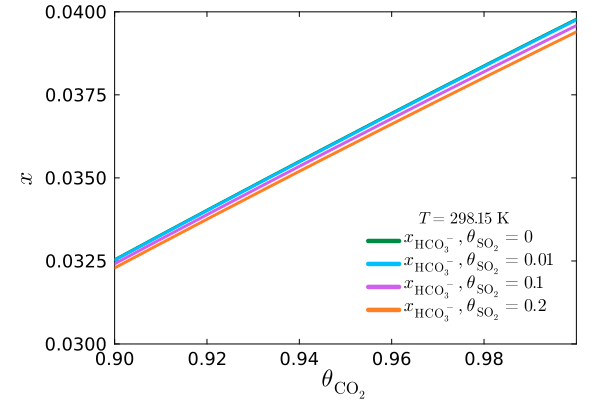

In [14]:
plt8 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle = L"T = 298.15 \ \mathrm{K}",
      xtickfont = font(12),
      ytickfont = font(12),
      xlims = (0.9, 1),
      ylims = (0.03, 0.04),
      legend =:bottomright,
      left_margin = 4mm,
      right_margin = 4mm,
      xguidefontsize=16,
      yguidefontsize=16)

# plot!(plt6, loadfil, xNHCOO_0, 
#       color = "springgreen4", 
#       line = (:path, 3), 
#       label = L"x_{\mathrm{NHCOO}^-}, \theta\mathrm{_{SO_2}} = 0")

plot!(plt8, loadfil, xHCO3_0, 
      color = "springgreen4", 
      line = (:path, 3), 
      label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0")

# plot!(plt6, loadfil, xNHCOO_001, 
#       color = "deepskyblue1", 
#       line = (:path, 3), 
#       label = L"x_{\mathrm{NHCOO}^-}, \theta\mathrm{_{SO_2}} = 0.01")

plot!(plt8, loadfil, xHCO3_001, 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0.01")

# plot!(plt6, loadfil, xNHCOO_01, 
#       color = "mediumorchid2", 
#       line = (:path, 3), 
#       label = L"x_{\mathrm{NHCOO}^-}, \theta\mathrm{_{SO_2}} = 0.1")

plot!(plt8, loadfil, xHCO3_01, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0.1")

#=plot!(plt6, loadfil, xNHCOO_02, 
      color = "chocolate1", 
      line = (:path, 3), 
      label = L"x_{\mathrm{NHCOO}^-}, \theta\mathrm{_{SO_2}} = 0.2")=#

plot!(plt8, loadfil, xHCO3_02, 
      color = "chocolate1", 
      line = (:path, 3), 
      label = L"x_{\mathrm{HCO}_3^-}, \theta\mathrm{_{SO_2}} = 0.2")

xlabel!(plt8, L"\theta_{\mathrm{CO_2}}")
ylabel!(plt8, L"x")
#savefig(plt8, "HCO3_Speciation_SO2_loading_Effect_CO2.png")
#savefig(plt8, "C:\\Users\\gk321\\OneDrive - Imperial College London\\Documents\\4th year\\Research Project\\Fitted SO2 CO2 Figures\\EPSILONFITTED_HCO3_Speciation_SO2_loading_Effect_CO2.png")

In [15]:
df = DataFrame(
    CO2_Loading = load[:],
    x_MEA_0 = z[:,1],
    x_H2O_0 = z[:,2],
    x_CO2_0 = z[:,3],
    x_SO2_0 = z[:,4],
    y_MEA_0 = y[:,1],
    y_H2O_0 = y[:,2],
    y_CO2_0 = y[:,3],
    y_SO2_0 = y[:,4],
    x_NHCOO_0 = xNHCOO[:,1],
    x_HCO3_0 = xHCO3[:,1],
    vapour_pressure_0 = pvap[:,1],
    x_MEA_001 = z[:,5],
    x_H2O_001 = z[:,6],
    x_CO2_001 = z[:,7],
    x_SO2_001 = z[:,8],
    y_MEA_001 = y[:,5],
    y_H2O_001 = y[:,6],
    y_CO2_001 = y[:,7],
    y_SO2_001 = y[:,8],
    x_NHCOO_001 = xNHCOO[:,2],
    x_HCO3_001 = xHCO3[:,2],
    vapour_pressure_001 = pvap[:,2],
    x_MEA_01 = z[:,9],
    x_H2O_01 = z[:,10],
    x_CO2_01 = z[:,11],
    x_SO2_01 = z[:,12],
    y_MEA_01 = y[:,9],
    y_H2O_01 = y[:,10],
    y_CO2_01 = y[:,11],
    y_SO2_01 = y[:,12],
    x_NHCOO_01 = xNHCOO[:,3],
    x_HCO3_01 = xHCO3[:,3],
    vapour_pressure_01 = pvap[:,3],
    x_MEA_02 = z[:,13],
    x_H2O_02 = z[:,14],
    x_CO2_02 = z[:,15],
    x_SO2_02 = z[:,16],
    y_MEA_02 = y[:,13],
    y_H2O_02 = y[:,14],
    y_CO2_02 = y[:,15],
    y_SO2_02 = y[:,16],
    x_NHCOO_02 = xNHCOO[:,4],
    x_HCO3_02 = xHCO3[:,4],
    vapour_pressure_02 = pvap[:,4])

#CSV.write("SO2_Effect_CO2_Data_293.csv", df)

Row,CO2_Loading,x_MEA_0,x_H2O_0,x_CO2_0,x_SO2_0,y_MEA_0,y_H2O_0,y_CO2_0,y_SO2_0,x_NHCOO_0,x_HCO3_0,vapour_pressure_0,x_MEA_001,x_H2O_001,x_CO2_001,x_SO2_001,y_MEA_001,y_H2O_001,y_CO2_001,y_SO2_001,x_NHCOO_001,x_HCO3_001,vapour_pressure_001,x_MEA_01,x_H2O_01,x_CO2_01,x_SO2_01,y_MEA_01,y_H2O_01,y_CO2_01,y_SO2_01,x_NHCOO_01,x_HCO3_01,vapour_pressure_01,x_MEA_02,x_H2O_02,x_CO2_02,x_SO2_02,y_MEA_02,y_H2O_02,y_CO2_02,y_SO2_02,x_NHCOO_02,x_HCO3_02,vapour_pressure_02
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.11222,0.88778,0.0,0.0,0.000583615,0.999416,0.0,0.0,0.0,0.0,2713.29,0.112094,0.886785,0.0,0.00112094,0.000333547,0.57836,0.0,0.421306,0.0,0.0,4701.98,0.110975,0.877928,0.0,0.0110975,6.51346e-5,0.126132,0.0,0.873803,0.0,0.0,21875.7,0.109757,0.868292,0.0,0.0219513,3.24538e-5,0.0707782,0.0,0.929189,0.0,0.0,39528.0
2,0.0121212,0.112068,0.886574,0.0013584,0.0,0.000567687,0.999398,3.44551e-5,0.0,0.00135698,1.41381e-6,2718.4,0.111942,0.885582,0.00135687,0.00111942,0.000325954,0.581034,1.98453e-5,0.41862,0.00135546,1.4143e-6,4689.02,0.110826,0.876748,0.00134334,0.0110826,6.39588e-5,0.127313,4.00547e-6,0.872619,0.00134192,1.41861e-6,21712.6,0.109611,0.867138,0.00132862,0.0219222,3.18804e-5,0.0714607,2.06036e-6,0.928505,0.00132719,1.42322e-6,39221.8
3,0.0242424,0.111916,0.885371,0.00271311,0.0,0.000551904,0.999376,7.25112e-5,0.0,0.00271019,2.91828e-6,2723.53,0.11179,0.884382,0.00271007,0.0011179,0.000318352,0.583692,4.19584e-5,0.415947,0.00270715,2.91926e-6,4676.33,0.110677,0.875572,0.00268308,0.0110677,6.27682e-5,0.128499,8.51164e-6,0.871429,0.00268015,2.92794e-6,21551.7,0.109465,0.865988,0.00265371,0.0218931,3.1299e-5,0.0721472,4.38104e-6,0.927817,0.00265077,2.93724e-6,38919.5
4,0.0363636,0.111764,0.884172,0.00406415,0.0,0.00053627,0.999349,0.000114602,0.0,0.00405962,4.52066e-6,2728.68,0.111639,0.883185,0.00405961,0.00111639,0.000310746,0.586336,6.66188e-5,0.413287,0.00405509,4.52214e-6,4663.89,0.110529,0.874399,0.00401922,0.0110529,6.15635e-5,0.129692,1.35828e-5,0.870233,0.00401469,4.53526e-6,21392.9,0.10932,0.86484,0.00397529,0.0218641,3.07101e-5,0.0728376,6.99569e-6,0.927125,0.00397074,4.54929e-6,38621.0
5,0.0484848,0.111613,0.882976,0.00541153,0.0,0.000520789,0.999318,0.000161224,0.0,0.0054053,6.22897e-6,2733.86,0.111488,0.881991,0.0054055,0.00111488,0.000303139,0.588963,9.4147e-5,0.410639,0.00539926,6.23096e-6,4651.7,0.110381,0.873229,0.0053518,0.0110381,6.03454e-5,0.130889,1.9293e-5,0.869031,0.00534555,6.24858e-6,21236.2,0.109176,0.863696,0.00529337,0.0218351,3.01141e-5,0.073532,9.943e-6,0.926428,0.0052871,6.26742e-6,38326.2
6,0.0606061,0.111462,0.881783,0.00675527,0.0,0.000505466,0.999282,0.000212947,0.0,0.00674722,8.0521e-6,2739.06,0.111338,0.880801,0.00674775,0.00111338,0.000295538,0.591575,0.000124912,0.408004,0.0067397,8.05462e-6,4639.76,0.110233,0.872063,0.00668081,0.0110233,5.91148e-5,0.132092,2.57274e-5,0.867823,0.00667273,8.0768e-6,21081.6,0.109031,0.862554,0.00660796,0.0218063,2.95111e-5,0.0742304,1.32676e-5,0.925727,0.00659986,8.10051e-6,38035.0
7,0.0727273,0.111312,0.880593,0.00809539,0.0,0.000490307,0.999239,0.000270429,0.0,0.00808539,9.99997e-6,2744.29,0.111188,0.879614,0.00808639,0.00111188,0.000287946,0.594171,0.000159339,0.405382,0.00807638,1.0003e-5,4628.08,0.110086,0.870899,0.00800627,0.0110086,5.78725e-5,0.133301,3.29849e-5,0.866608,0.00799624,1.00298e-5,20928.9,0.108888,0.861416,0.00791909,0.0217775,2.89017e-5,0.0749327,1.70213e-5,0.925021,0.00790903,1.00585e-5,37747.4
8,0.0848485,0.111162,0.879406,0.0094319,0.0,0.000475316,0.99919,0.000334429,0.0,0.00941981,1.20836e-5,2749.55,0.111038,0.87843,0.00942142,0.00111038,0.000280369,0.59675,0.000197921,0.402772,0.00940933,1.20872e-5,4616.64,0.10994